## 1. <Directed Acyclic Graph 구현을 위한 데이터 전처리 코드>

###   1) 총 시뮬레이션 시간 동안의 노드 간 연기 이동 방향 분석
- Stationary dBN
- Non-stationary dBN

#### (1) 노드 간 연기 이동 전처리 -> 데이터 프레임화

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import IPython

In [2]:
# node(Labelized Variable)별 space aim number(xml space name) -> node numbering dictionary
xml2node_code = {'3252':'r1', '3300':'r2', '3348':'r3', '3396':'r4', '3344':'r5', '3492':'r6',
               '2594':'r7', '2642':'r8', '2695':'r9', '1715':'r10', '1773':'r11', '0390':'r12',
               '0438':'r13', '0491':'r14', '3093':'r15', '3151':'r16', '3204':'r17', '1836':'r18', 
               '1899':'r19', '0909':'r20', '0967':'r21', '1020':'r22', '0080':'r23', '0193':'r24', 
                '0241':'r25', '0294':'r26', '0342':'r27', '2154':'r28', '1275':'r29', '2435':'r30',
               '1556':'r31', '2207':'r32', '2260':'r33', '2313':'r34', '1328':'r35', '1381':'r36',
               '1434':'r37', '2753':'r38', '2806':'r39', '2870':'r40', '2923':'r41', '2976':'r42',
               '3040':'r43', '1947':'r44', '2000':'r45', '1068':'r46', '1121':'r47', '2488':'r48',
               '2541':'r49', '1609':'r50', '1662':'r51', '0549':'r52', '0602':'r53', '0676':'r54',
               '0729':'r55', '0782':'r56', '0856':'r57', '2058':'r58', '3540':'r59', '1179':'r60',
               '3609':'r61', '2366':'r62', '3678':'r63', '1487':'r64', '3774':'r65'}

df_mafldensity_raw = pd.read_csv('d.massfluxdensity/analysis_md_aim0549.csv', encoding='utf-8')
# df_mafldensity_raw: 각 time 당 두 room 사이의 mass flux density 이동량
df_mafldensity_raw['Time'] = df_mafldensity_raw['Time'].map(lambda x: int(str(x).split('.')[0])) # time column 소숫점 자리 제거

# raw dataframe melting : [Time] column data -> id_vars, column에 있는 variables -> var_name, 기존데이터 value값 -> MassFluxDensity(kg/s)
df_mafldensity_raw = df_mafldensity_raw.melt(id_vars=['Time'], var_name = 'roomij(i_j)', value_name = 'MassFluxDensity(kg/s)')

In [3]:
# roomij(i_j)에 있는 값을 '_'로 전부 분리해서 정리
df_mafldensity_raw['room i'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[1])
df_mafldensity_raw['room j'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[2])
df_mafldensity_raw = df_mafldensity_raw.drop('roomij(i_j)', axis = 1)
df_mafldensity_raw.replace({'room i':xml2node_code}, inplace = True)
df_mafldensity_raw.replace({'room j':xml2node_code}, inplace = True)

In [4]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r44,r45
1,1,0.000000,r44,r45
2,2,0.000000,r44,r45
3,3,0.000000,r44,r45
4,4,0.000000,r44,r45
...,...,...,...,...
29995,395,0.001772,r65,r57
29996,396,0.001609,r65,r57
29997,397,0.001791,r65,r57
29998,398,0.001875,r65,r57


In [5]:
# 총 시뮬레이션 시간 동안 space 간 연기 이동이 없는 경우가 있는지 확인
df_Smafldensity = df_mafldensity_raw.groupby(by=['room i', 'room j']).sum().reset_index()
if len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]) == 0:
    pass
else:
    print(len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]))

In [6]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r44,r45
1,1,0.000000,r44,r45
2,2,0.000000,r44,r45
3,3,0.000000,r44,r45
4,4,0.000000,r44,r45
...,...,...,...,...
29995,395,0.001772,r65,r57
29996,396,0.001609,r65,r57
29997,397,0.001791,r65,r57
29998,398,0.001875,r65,r57


In [7]:
# dataframe 정리
df_mafldensity_raw['room ini'], df_mafldensity_raw['room fin'] = "", ""
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r44,r45,,
1,1,0.000000,r44,r45,,
2,2,0.000000,r44,r45,,
3,3,0.000000,r44,r45,,
4,4,0.000000,r44,r45,,
...,...,...,...,...,...,...
29995,395,0.001772,r65,r57,,
29996,396,0.001609,r65,r57,,
29997,397,0.001791,r65,r57,,
29998,398,0.001875,r65,r57,,


#### (2) 노드 간 연기 이동 "방향" 판단 -> 데이터 프레임 column 추가: 출발 room - [room ini], 도착 room - [room fin]
- relationship modeling.xlsx - room간 방향성을 모델링한 파일
- 예를 들어, r65가 r57보다 위에 있기 때문에, massfluxdensity값이 양수이면 massflux가 일어난 방향이 r57 -> r65임.
- 이것은 DAG 결정에 있어 중요한 증거이기 때문에 분석에 추가하였음.
- 같은 room들 간 이동이어도 매초마다 양수일 수도 음수일 수도 있으므로 더 우세한 쪽의 방향을 따르는 것이 맞음.

###### 이를 위해서 분석 자동화 코드는 다음을 포함한다.
   1) 같은 room들 간 이동에서, massfluxdensity가 양수인 경우의 수와 음수인 경우의 수를 세어 비교
   2) sum값의 부호가 1)의 우세한 부호와 일지하는지 확인

In [8]:
room_relation = pd.read_csv('d.others/relationship_modeling.csv', encoding='utf-8')

index_name = []
for colname in room_relation.columns[:]:
    index_name.append('r{}'.format(colname))
    room_relation.rename(columns = {colname:'r{}'.format(colname)}, inplace=True)

room_relation.index = pd.Series(index_name)

In [9]:
room_relation = room_relation.replace('-', np.nan)
room_relation

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r56,r57,r58,r59,r60,r61,r62,r63,r64,r65
r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,-1,NaN,NaN,NaN,NaN,NaN
r62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,NaN
r63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1
r64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1


In [10]:
# room_relation 데이터 프레임에서 room과의 관계를 읽어, 정리된 df_mafldensity_raw 데이터 프레임에 적용
# 매초(time) 별로 어느 room에서 어떤 room으로 매연입자가 확산하는지를 판단하여 새 컬럼에 기록
df_mafldensity_values_list = df_mafldensity_raw.values.tolist()

for x in df_mafldensity_values_list:
    values_index = df_mafldensity_values_list.index(x)
    
    if int(room_relation.loc[x[2], x[3]]) * x[1] > 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[2]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[3]
        
    elif int(room_relation.loc[x[2], x[3]]) * x[1] < 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[3]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[2]
        
    else:
        df_mafldensity_raw.loc[values_index, 'room ini'] = np.nan
        df_mafldensity_raw.loc[values_index, 'room fin'] = np.nan

df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r44,r45,NaN,NaN
1,1,0.000000,r44,r45,NaN,NaN
2,2,0.000000,r44,r45,NaN,NaN
3,3,0.000000,r44,r45,NaN,NaN
4,4,0.000000,r44,r45,NaN,NaN
...,...,...,...,...,...,...
29995,395,0.001772,r65,r57,r57,r65
29996,396,0.001609,r65,r57,r57,r65
29997,397,0.001791,r65,r57,r57,r65
29998,398,0.001875,r65,r57,r57,r65


In [11]:
# 전처리된 room 간 연기 이동 데이터프레임 -> out
df_mafldensity_tidy = df_mafldensity_raw.copy()
df_mafldensity_tidy.to_csv("r.preprocessed/0549(52).csv")

In [12]:
df_mafldensity_tidy['room i_j'] = df_mafldensity_tidy['room i']+'_'+df_mafldensity_tidy['room j']
df_mafldensity_tidy.drop(columns=['room i', 'room j'], inplace = True)
df_mafldensity_tidy['room ini_fin'] = df_mafldensity_tidy['room ini']+'_'+df_mafldensity_tidy['room fin']
df_mafldensity_tidy.drop(columns=['room ini', 'room fin'], inplace = True)

In [13]:
grouped=df_mafldensity_tidy.groupby(['room i_j', 'room ini_fin']).count()
grouped.reset_index(level=['room i_j', 'room ini_fin'], inplace = True)
list_grouped_values = grouped.values.tolist()

In [14]:
list_grouped_values

[['r10_r46', 'r10_r46', 33, 33],
 ['r10_r46', 'r46_r10', 263, 263],
 ['r11_r47', 'r11_r47', 129, 129],
 ['r11_r47', 'r47_r11', 159, 159],
 ['r15_r48', 'r48_r15', 204, 204],
 ['r16_r49', 'r49_r16', 197, 197],
 ['r17_r49', 'r49_r17', 193, 193],
 ['r1_r38', 'r38_r1', 326, 326],
 ['r20_r50', 'r50_r20', 262, 262],
 ['r21_r51', 'r51_r21', 255, 255],
 ['r23_r52', 'r23_r52', 2, 2],
 ['r23_r52', 'r52_r23', 327, 327],
 ['r27_r57', 'r57_r27', 298, 298],
 ['r29_r60', 'r60_r29', 357, 357],
 ['r2_r39', 'r39_r2', 315, 315],
 ['r30_r63', 'r63_r30', 239, 239],
 ['r31_r65', 'r65_r31', 295, 295],
 ['r32_r40', 'r40_r32', 289, 289],
 ['r33_r40', 'r40_r33', 277, 277],
 ['r34_r41', 'r41_r34', 260, 260],
 ['r35_r54', 'r54_r35', 328, 328],
 ['r36_r54', 'r54_r36', 319, 319],
 ['r37_r55', 'r55_r37', 310, 310],
 ['r38_r39', 'r38_r39', 334, 334],
 ['r38_r58', 'r58_r38', 352, 352],
 ['r39_r40', 'r39_r40', 312, 312],
 ['r39_r59', 'r59_r39', 336, 336],
 ['r3_r40', 'r40_r3', 274, 274],
 ['r40_r41', 'r40_r41', 284, 284

In [15]:
smoke_move_relation = []
for li in range(len(list_grouped_values)+1):
    if li+1 < len(list_grouped_values):
        list_this_turn = list_grouped_values[li]
        list_next_turn = list_grouped_values[li+1]
        
        if list_this_turn[0] == list_next_turn[0]:
            if list_this_turn[2] > list_next_turn[2]:
                smoke_move_relation.append(list_this_turn[1])
            elif list_this_turn[2] < list_next_turn[2]:
                smoke_move_relation.append(list_next_turn[1])
            else:
                smoke_move_relation.append('identical')
        
        else:
            reverse_list_this_turn = list_this_turn[1].split('_')[1] + '_' + list_this_turn[1].split('_')[0]
            if smoke_move_relation.count(list_this_turn[1]) == 0 and smoke_move_relation.count(reverse_list_this_turn) == 0:
                if smoke_move_relation[-1] != list_this_turn[0]:
                    smoke_move_relation.append(list_this_turn[1])
                
                    if (list_next_turn == list_grouped_values[-1]) and (smoke_move_relation.count(list_next_turn[1]) == 0):
                        smoke_move_relation.append(list_next_turn[1])
                
                
                
len(smoke_move_relation)

75

In [16]:
pair_of_smr = [tuple(x.split('_')) for x in smoke_move_relation]
pair_of_smr0 = [tuple (y+'_0' for y in tuple(x.split('_'))) for x in smoke_move_relation]
pair_of_smrt = [tuple (y+'_t' for y in tuple(x.split('_'))) for x in smoke_move_relation]

In [17]:
pair_of_smr

[('r46', 'r10'),
 ('r47', 'r11'),
 ('r48', 'r15'),
 ('r49', 'r16'),
 ('r49', 'r17'),
 ('r38', 'r1'),
 ('r50', 'r20'),
 ('r51', 'r21'),
 ('r52', 'r23'),
 ('r57', 'r27'),
 ('r60', 'r29'),
 ('r39', 'r2'),
 ('r63', 'r30'),
 ('r65', 'r31'),
 ('r40', 'r32'),
 ('r40', 'r33'),
 ('r41', 'r34'),
 ('r54', 'r35'),
 ('r54', 'r36'),
 ('r55', 'r37'),
 ('r38', 'r39'),
 ('r58', 'r38'),
 ('r39', 'r40'),
 ('r59', 'r39'),
 ('r40', 'r3'),
 ('r40', 'r41'),
 ('r41', 'r42'),
 ('r42', 'r43'),
 ('r42', 'r62'),
 ('r63', 'r43'),
 ('r44', 'r10'),
 ('r45', 'r44'),
 ('r45', 'r11'),
 ('r58', 'r45'),
 ('r46', 'r12'),
 ('r46', 'r13'),
 ('r47', 'r46'),
 ('r47', 'r14'),
 ('r60', 'r47'),
 ('r48', 'r18'),
 ('r48', 'r49'),
 ('r49', 'r19'),
 ('r41', 'r4'),
 ('r50', 'r18'),
 ('r50', 'r51'),
 ('r51', 'r19'),
 ('r51', 'r22'),
 ('r52', 'r53'),
 ('r52', 'r60'),
 ('r53', 'r54'),
 ('r61', 'r53'),
 ('r54', 'r24'),
 ('r54', 'r55'),
 ('r55', 'r25'),
 ('r55', 'r56'),
 ('r56', 'r26'),
 ('r56', 'r57'),
 ('r58', 'r28'),
 ('r58', 'r59'),
 

#### (3) 노드 간 연기 이동 "방향"으로 시각화 -> DAG 결정

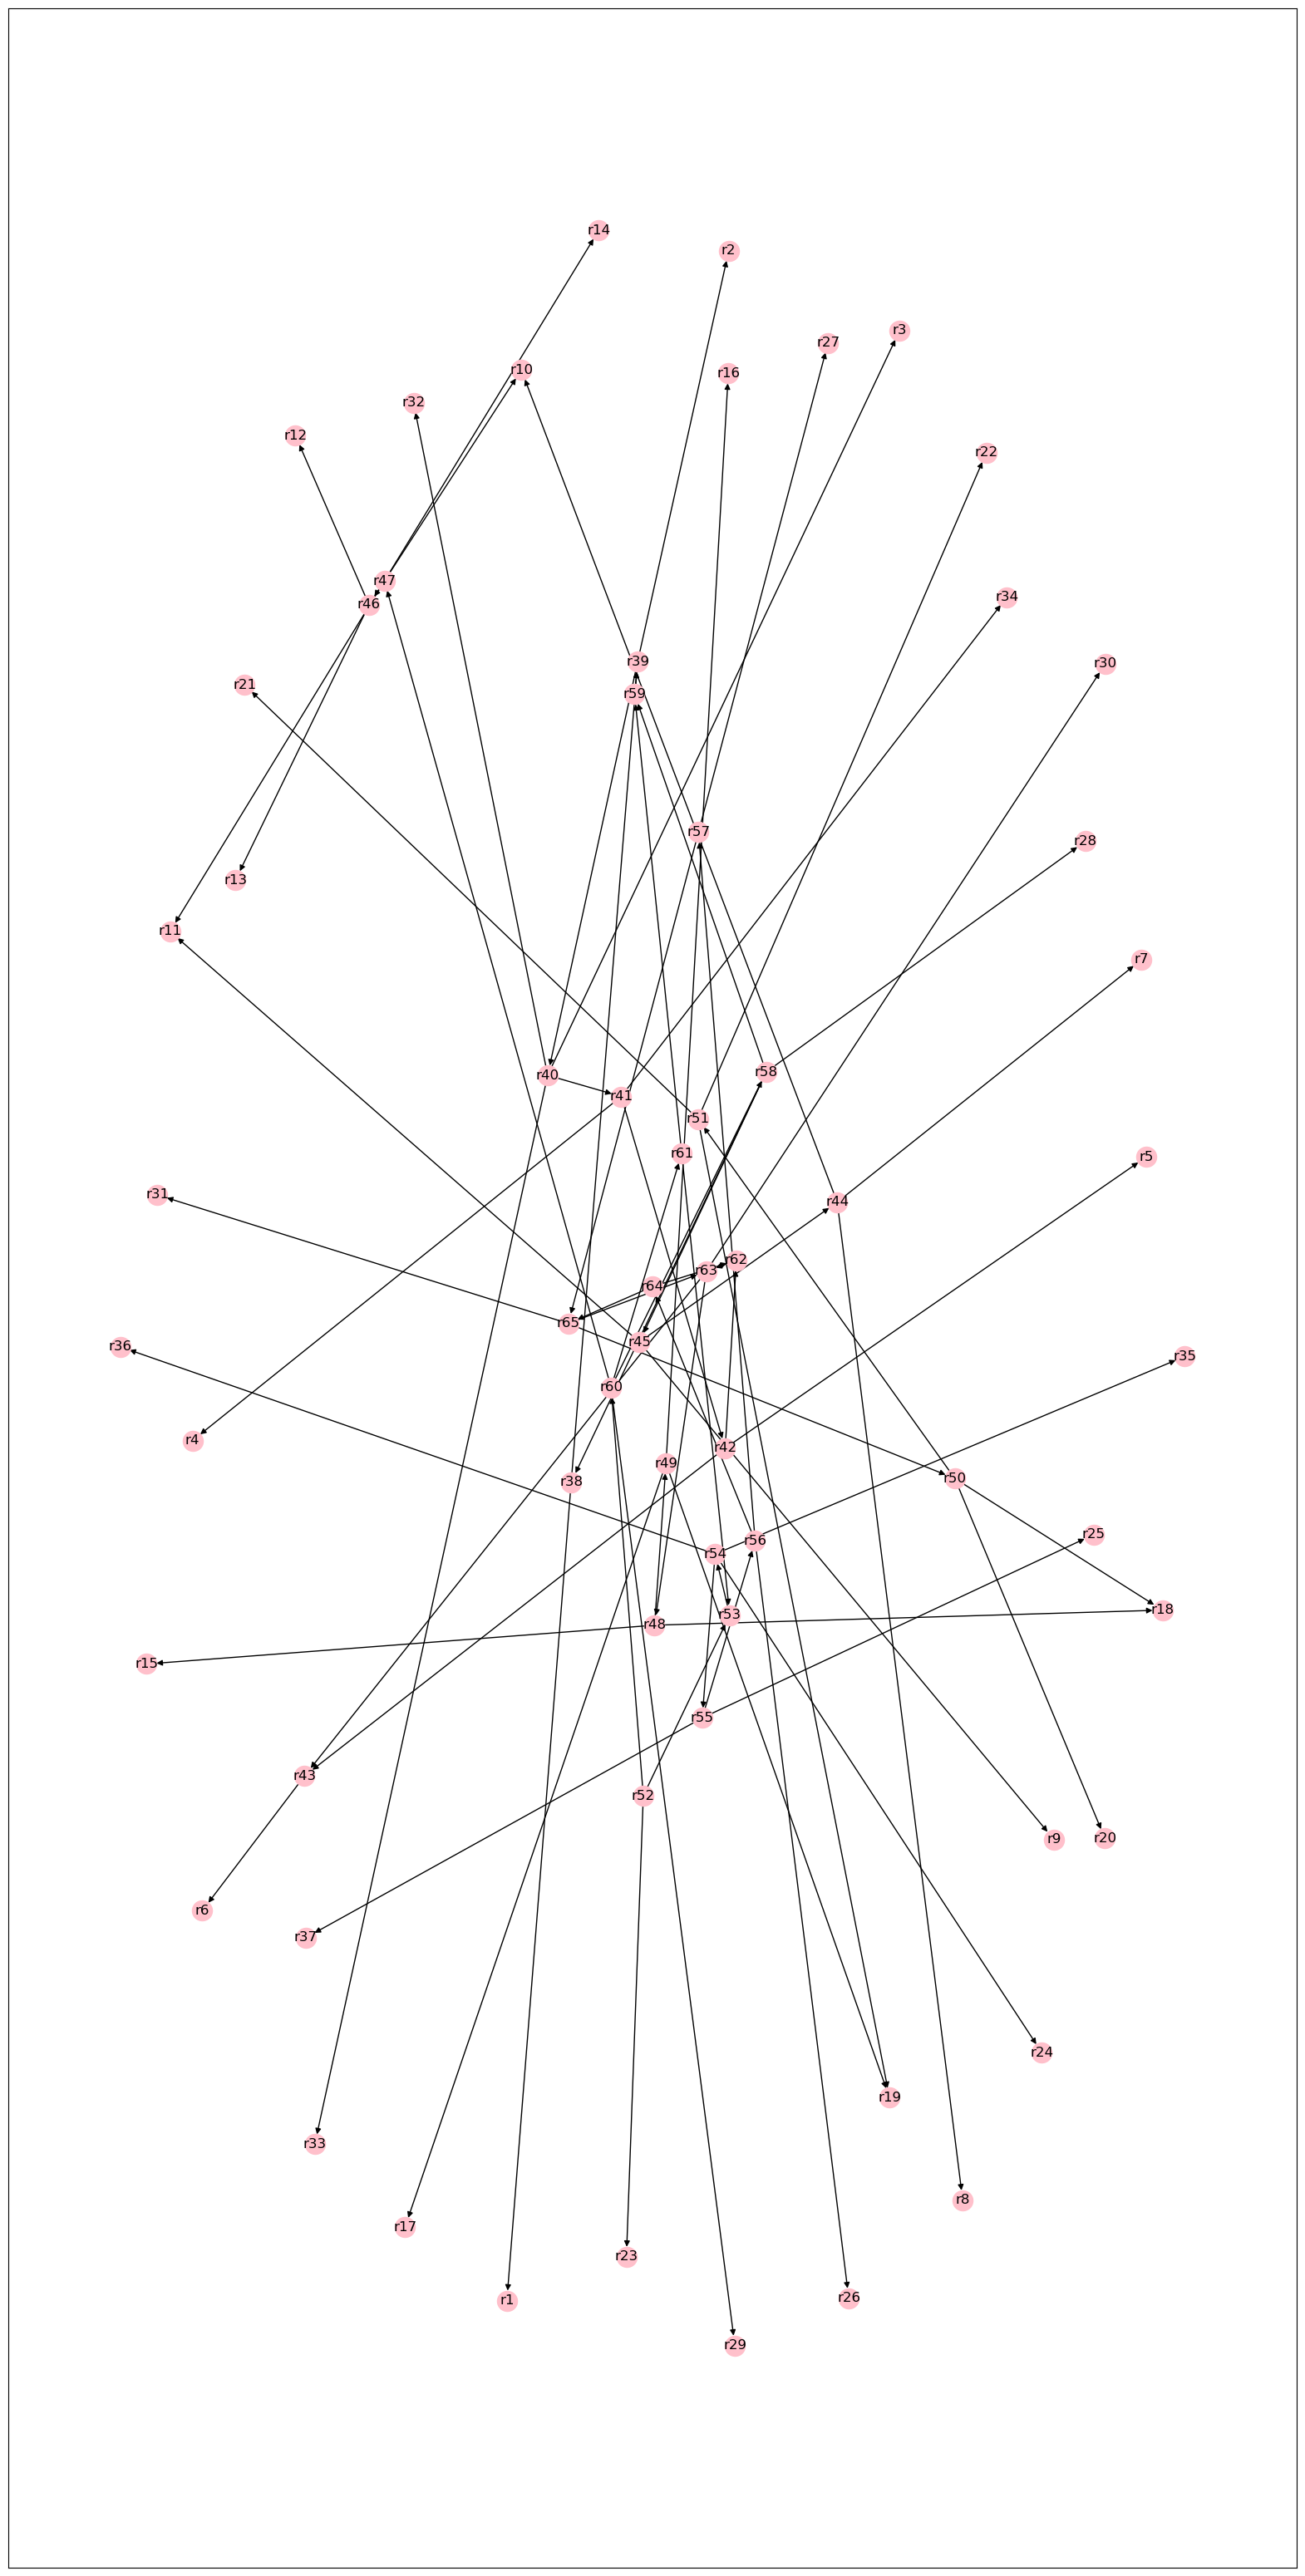

In [18]:
figures = []
plt.figure(figsize=(20,40))
G = nx.DiGraph()
G.add_edges_from(pair_of_smr)
nx.draw_networkx(G, arrows = True, node_color = 'pink')
figures.append(G)
plt.savefig('r.dag/0549(52).png')

## 2. <PyArgum 라이브러리를 이용한 동적 베이지안 네트워크 구현>

###   unStationary dBN (nsDBN)
 - DAG 유지, 확률변화 (CPT 변화 DBN만들기)

In [19]:
import pyAgrum as gum
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.lib.notebook as gnb

In [20]:
dag_dBN = gum.BayesNet('0549(52)')
dag_nodes = list(G.nodes)
dBN_nodes = []

for node in dag_nodes:
    globals()[node+'_0'] = dag_dBN.add(gum.LabelizedVariable(node+'_0',node+'_0',2))
    globals()[node+'_t'] = dag_dBN.add(gum.LabelizedVariable(node+'_t',node+'_t',2))
    dBN_nodes.append(node+'_0')
    dBN_nodes.append(node+'_t')
    
pair_of_self = [(node+'_0', node+'_t') for node in dag_nodes]
for link in pair_of_smr0:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_smrt:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_self:
    dag_dBN.addArc(*link)

BN{nodes: 130, arcs: 75, domainSize: 10^39.1339, dim: 216, mem: 3Ko 384o}
BN{nodes: 130, arcs: 150, domainSize: 10^39.1339, dim: 302, mem: 4Ko 736o}


In [26]:
dag_dBN.cpt('r1_0')

(pyAgrum.Potential<double>@000001180964D4D0) 
      ||  r1_0             |
r38_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |

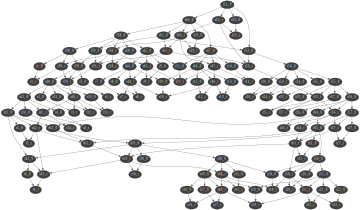

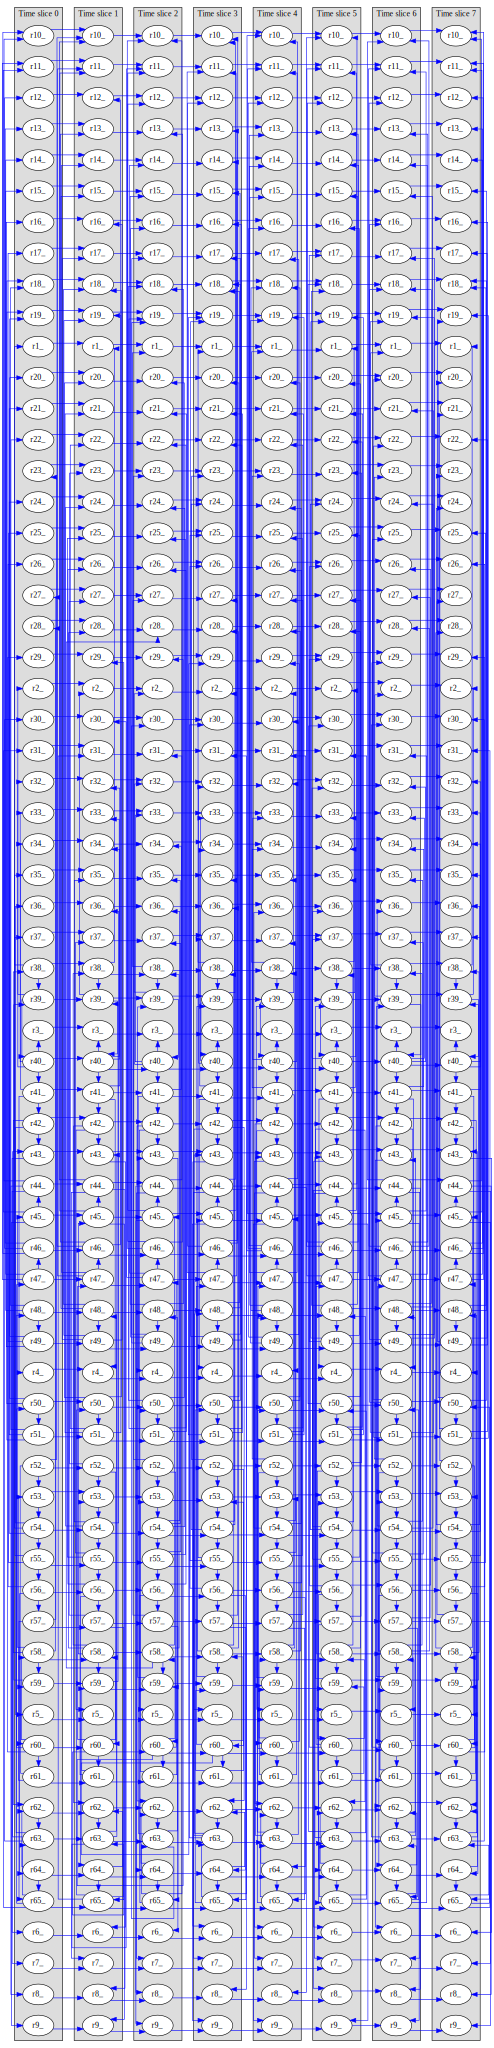

In [27]:
T = 8

gnb.showBN(dag_dBN)

ftts_dbn = gdyn.unroll2TBN(dag_dBN, T)
gdyn.showTimeSlices(ftts_dbn, size="30")

In [28]:
ftts_dbn_nodes = ftts_dbn.names()
ts_0 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) == 0)])
ts_1 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(1, 2))])

In [29]:
ts_2to3 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(2, 4))])
ts_4to5 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(4, 6))])
ts_6to7 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(6, 8))])

In [31]:
ftts_dbn.cpt('r36_0')

(pyAgrum.Potential<double>@000001180CC8DA60) 
      ||  r36_0            |
r54_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |

In [32]:
cpt_0 =[[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0045,0.9955,0.0055,0.9945,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[1, 0],[0.0047,0.9953,0.0000,1.0000,0.0047,0.9953,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0046,0.9954,0.0054,0.9946,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0100,0.9900,0.0058,0.9942,0.0042,0.9958,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000]]
cpt_1 = [[1.0000,0.0000,0.3724,0.6276,0.3724,0.6276,0.3724,0.6276,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.3311,0.6689,0.3311,0.6689,0.3311,0.6689,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.5244,0.4756,0.2894,0.7106,0.0000,1.0000],[1.0000,0.0000,0.4531,0.5469,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.3833,0.6167,0.2943,0.7057,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.4614,0.5386,0.2591,0.7409,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.1686,0.8314,0.2028,0.7972,0.0000,1.0000],[1.0000,0.0000,0.3873,0.6127,0.3153,0.6847,0.0000,1.0000],[1.0000,0.0000,0.4382,0.5618,0.3405,0.6595,0.0000,1.0000],[1.0000,0.0000,0.4688,0.5312,0.3560,0.6440,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.5575,0.4425,0.2891,0.7109,0.0000,1.0000],[1.0000,0.0000,0.2318,0.7682,0.1607,0.8393,0.0000,1.0000],[1.0000,0.0000,0.4978,0.5022,0.2933,0.7067,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.6545,0.3455,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.3092,0.6908,0.2583,0.7417,0.0000,1.0000],[1.0000,0.0000,0.3503,0.6497,0.3232,0.6768,0.0000,1.0000],[1.0000,0.0000,0.4540,0.5460,0.3402,0.6598,0.0000,1.0000],[1.0000,0.0000,0.2391,0.7609,0.2409,0.7591,0.0000,1.0000],[1.0000,0.0000,0.4100,0.5900,0.4578,0.5422,0.2206,0.7794,0.4266,0.5734,0.1893,0.8107,0.2372,0.7628,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.4478,0.5522,0.4271,0.5729,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.4168,0.5832,0.3175,0.6825,0.0000,1.0000],[1.0000,0.0000,0.0329,0.9671,0.2441,0.7559,0.0000,1.0000],[1.0000,0.0000,0.2847,0.7153,0.2011,0.7989,0.0000,1.0000],[1.0000,0.0000,0.1521,0.8479,0.1204,0.8796,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[1.0000,0.0000,0.0543,0.9457,0.1277,0.8723,0.0543,0.9457,0.0734,0.9266,0.0000,1.0000,0.0734,0.9266,0.0000,1.0000],[1.0000,0.0000,0.1681,0.8319,0.1719,0.8281,0.0000,1.0000],[1.0000,0.0000,0.2522,0.7478,0.2578,0.7422,0.0000,1.0000],[1.0000,0.0000,0.3478,0.6522,0.3322,0.6678,0.0000,1.0000],[1.0000,0.0000,0.4233,0.5767,0.4217,0.5783,0.0000,1.0000],[1.0000,0.0000,0.1688,0.8312,0.1712,0.8288,0.0000,1.0000],[1.0000,0.0000,0.3271,0.6729,0.4555,0.5445,0.1943,0.8057,0.3940,0.6060,0.1328,0.8672,0.2612,0.7388,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.0687,0.9313,0.0865,0.9135,0.0000,1.0000],[1.0000,0.0000,0.1147,0.8853,0.1196,0.8804,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.4966,0.5034,0.2834,0.7166,0.0000,1.0000],[1.0000,0.0000,0.6186,0.3814,0.5368,0.4632,0.3091,0.6909,0.5372,0.4628,0.3095,0.6905,0.2278,0.7722,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.5901,0.4099,0.0000,1.0000,0.0000,1.0000]]
cpt_2to3 = [[1.0000,0.0000,0.3904,0.6096,0.3724,0.6276,0.2140,0.7860,0.3348,0.6652,0.1764,0.8236,0.1584,0.8416,0.0000,1.0000],[1.0000,0.0000,0.3614,0.6386,0.3640,0.6360,0.2019,0.7981,0.3216,0.6784,0.1595,0.8405,0.1621,0.8379,0.0000,1.0000],[1.0000,0.0000,0.3278,0.6722,0.1722,0.8278,0.0000,1.0000],[1.0000,0.0000,0.3432,0.6568,0.1646,0.8354,0.0000,1.0000],[1.0000,0.0000,0.3249,0.6751,0.1751,0.8249,0.0000,1.0000],[1.0000,0.0000,0.6069,0.3931,0.3080,0.6920,0.0000,1.0000],[1.0000,0.0000,0.6547,0.3453,0.3538,0.6462,0.0000,1.0000],[1.0000,0.0000,0.7384,0.2616,0.2930,0.7070,0.0000,1.0000],[1.0000,0.0000,0.6215,0.3785,0.6141,0.3859,0.3681,0.6319,0.4994,0.5006,0.2534,0.7466,0.2460,0.7540,0.0000,1.0000],[1.0000,0.0000,0.4754,0.5246,0.6328,0.3672,0.3210,0.6790,0.4662,0.5338,0.1544,0.8456,0.3118,0.6882,0.0000,1.0000],[0.5000,0.5000,0.3249,0.6751,0.1751,0.8249,0.0000,1.0000],[1.0000,0.0000,0.3918,0.6082,0.2709,0.7291,0.0000,1.0000],[1.0000,0.0000,0.4199,0.5801,0.2805,0.7195,0.0000,1.0000],[1.0000,0.0000,0.4801,0.5199,0.2516,0.7484,0.0000,1.0000],[1.0000,0.0000,0.3011,0.6989,0.1989,0.8011,0.0000,1.0000],[1.0000,0.0000,0.3123,0.6877,0.1877,0.8123,0.0000,1.0000],[1.0000,0.0000,0.3043,0.6957,0.1957,0.8043,0.0000,1.0000],[1.0000,0.0000,0.3044,0.6956,0.1956,0.8044,0.0000,1.0000],[1.0000,0.0000,0.3204,0.6796,0.1865,0.8135,0.0000,1.0000],[1.0000,0.0000,0.3279,0.6721,0.1721,0.8279,0.0000,1.0000],[1.0000,0.0000,0.3132,0.6868,0.1868,0.8132,0.0000,1.0000],[1.0000,0.0000,0.3275,0.6725,0.1725,0.8275,0.0000,1.0000],[1.0000,0.0000,0.5449,0.4551,0.2601,0.7399,0.0000,1.0000],[1.0000,0.0000,0.3374,0.6626,0.1691,0.8309,0.0000,1.0000],[1.0000,0.0000,0.3402,0.6598,0.2085,0.7915,0.0000,1.0000],[1.0000,0.0000,0.3572,0.6428,0.2277,0.7723,0.0000,1.0000],[1.0000,0.0000,0.4066,0.5934,0.2621,0.7379,0.0000,1.0000],[1.0000,0.0000,0.3155,0.6845,0.1845,0.8155,0.0000,1.0000],[1.0000,0.0000,0.3184,0.6816,0.1816,0.8184,0.0000,1.0000],[1.0000,0.0000,0.3110,0.6890,0.1890,0.8110,0.0000,1.0000],[1.0000,0.0000,0.2490,0.7510,0.2510,0.7490,0.0000,1.0000],[1.0000,0.0000,0.3203,0.6797,0.3521,0.6479,0.1724,0.8276,0.3276,0.6724,0.1479,0.8521,0.1797,0.8203,0.0000,1.0000],[1.0000,0.0000,0.3781,0.6219,0.2489,0.7512,0.0000,1.0000],[1.0000,0.0000,0.2573,0.7427,0.2427,0.7573,0.0000,1.0000],[1.0000,0.0000,0.3185,0.6815,0.2615,0.7385,0.0000,1.0000],[1.0000,0.0000,0.3962,0.6038,0.2817,0.7183,0.0000,1.0000],[1.0000,0.0000,0.5286,0.4714,0.4681,0.5319,0.3102,0.6898,0.3763,0.6237,0.2184,0.7816,0.1579,0.8421,0.0000,1.0000],[1.0000,0.0000,0.2855,0.7145,0.2145,0.7855,0.0000,1.0000],[1.0000,0.0000,0.2740,0.7260,0.2260,0.7740,0.0000,1.0000],[1.0000,0.0000,0.3029,0.6971,0.1971,0.8029,0.0000,1.0000],[1.0000,0.0000,0.2924,0.7076,0.2076,0.7924,0.0000,1.0000],[1.0000,0.0000,0.3599,0.6401,0.3124,0.6876,0.0000,1.0000],[1.0000,0.0000,0.4881,0.5119,0.3419,0.6581,0.0000,1.0000],[1.0000,0.0000,0.3903,0.6097,0.2479,0.7521,0.0000,1.0000],[1.0000,0.0000,0.2948,0.7052,0.2280,0.7720,0.0000,1.0000],[1.0000,0.0000,0.3604,0.6396,0.2446,0.7554,0.0000,1.0000],[0.5000,0.5000,0.0000,1.0000],[1.0000,0.0000,0.5049,0.4951,0.3192,0.6808,0.1596,0.8404,0.5049,0.4951,0.3452,0.6548,0.1596,0.8404,0.0000,1.0000],[1.0000,0.0000,0.2472,0.7528,0.2528,0.7472,0.0000,1.0000],[1.0000,0.0000,0.2472,0.7528,0.2528,0.7472,0.0000,1.0000],[1.0000,0.0000,0.2557,0.7443,0.2443,0.7557,0.0000,1.0000],[1.0000,0.0000,0.2490,0.7510,0.2510,0.7490,0.0000,1.0000],[1.0000,0.0000,0.2482,0.7518,0.2518,0.7482,0.0000,1.0000],[1.0000,0.0000,0.3407,0.6593,0.3616,0.6384,0.2023,0.7977,0.2977,0.7023,0.1384,0.8616,0.1593,0.8407,0.0000,1.0000],[1.0000,0.0000,0.5019,0.4981,0.2681,0.7319,0.0000,1.0000],[1.0000,0.0000,0.2455,0.7545,0.2545,0.7455,0.0000,1.0000],[1.0000,0.0000,0.2607,0.7393,0.2393,0.7607,0.0000,1.0000],[1.0000,0.0000,0.3403,0.6597,0.4829,0.5171,0.2128,0.7872,0.3975,0.6025,0.1275,0.8725,0.2701,0.7299,0.0000,1.0000],[1.0000,0.0000,0.3731,0.6269,0.4829,0.5171,0.2040,0.7960,0.4480,0.5520,0.1691,0.8309,0.2789,0.7211,0.0000,1.0000],[1.0000,0.0000,0.3183,0.6817,0.1817,0.8183,0.0000,1.0000],[1.0000,0.0000,0.3660,0.6340,0.3158,0.6842,0.1818,0.8182,0.3182,0.6818,0.1842,0.8158,0.1340,0.8660,0.0000,1.0000],[1.0000,0.0000,0.5070,0.4930,0.2748,0.7253,0.0000,1.0000],[1.0000,0.0000,0.3781,0.6219,0.1953,0.8047,0.0000,1.0000],[1.0000,0.0000,0.3651,0.6349,0.2211,0.7789,0.0000,1.0000],[1.0000,0.0000,0.3207,0.6793,0.2277,0.7723,0.0000,1.0000]]
cpt_4to5 = [[1.0000,0.0000,0.4636,0.5364,0.4885,0.5115,0.2854,0.7146,0.3813,0.6187,0.1782,0.8218,0.2031,0.7969,0.0000,1.0000],[1.0000,0.0000,0.4737,0.5263,0.4622,0.5378,0.2692,0.7308,0.3975,0.6025,0.2045,0.7955,0.1930,0.8070,0.0000,1.0000],[1.0000,0.0000,0.4370,0.5630,0.2297,0.7703,0.0000,1.0000],[1.0000,0.0000,0.4576,0.5424,0.2090,0.7910,0.0000,1.0000],[1.0000,0.0000,0.4331,0.5669,0.2335,0.7665,0.0000,1.0000],[1.0000,0.0000,0.4571,0.5429,0.2095,0.7905,0.0000,1.0000],[1.0000,0.0000,0.4364,0.5636,0.2359,0.7641,0.0000,1.0000],[1.0000,0.0000,0.4923,0.5077,0.1953,0.8047,0.0000,1.0000],[1.0000,0.0000,0.4903,0.5097,0.4668,0.5332,0.2904,0.7096,0.3762,0.6238,0.1999,0.8001,0.1763,0.8237,0.0000,1.0000],[1.0000,0.0000,0.4639,0.5361,0.5423,0.4577,0.3344,0.6656,0.3373,0.6627,0.1294,0.8706,0.2079,0.7921,0.0000,1.0000],[1.0000,0.0000,0.4332,0.5668,0.2334,0.7666,0.0000,1.0000],[1.0000,0.0000,0.4049,0.5951,0.2617,0.7383,0.0000,1.0000],[1.0000,0.0000,0.4087,0.5913,0.2580,0.7420,0.0000,1.0000],[1.0000,0.0000,0.4384,0.5616,0.2282,0.7718,0.0000,1.0000],[1.0000,0.0000,0.4015,0.5985,0.2652,0.7348,0.0000,1.0000],[1.0000,0.0000,0.4164,0.5836,0.2502,0.7498,0.0000,1.0000],[1.0000,0.0000,0.4057,0.5943,0.2609,0.7391,0.0000,1.0000],[1.0000,0.0000,0.4059,0.5941,0.2608,0.7392,0.0000,1.0000],[1.0000,0.0000,0.4229,0.5771,0.2438,0.7563,0.0000,1.0000],[1.0000,0.0000,0.4372,0.5628,0.2294,0.7706,0.0000,1.0000],[1.0000,0.0000,0.4176,0.5824,0.2491,0.7509,0.0000,1.0000],[1.0000,0.0000,0.4366,0.5634,0.2300,0.7700,0.0000,1.0000],[1.0000,0.0000,0.4513,0.5487,0.2154,0.7846,0.0000,1.0000],[1.0000,0.0000,0.4498,0.5502,0.2168,0.7832,0.0000,1.0000],[1.0000,0.0000,0.4162,0.5838,0.2505,0.7495,0.0000,1.0000],[1.0000,0.0000,0.4178,0.5822,0.2489,0.7511,0.0000,1.0000],[1.0000,0.0000,0.4171,0.5829,0.2496,0.7504,0.0000,1.0000],[1.0000,0.0000,0.4207,0.5793,0.2460,0.7540,0.0000,1.0000],[1.0000,0.0000,0.4246,0.5754,0.2421,0.7579,0.0000,1.0000],[1.0000,0.0000,0.4147,0.5853,0.2520,0.7480,0.0000,1.0000],[1.0000,0.0000,0.3320,0.6680,0.3346,0.6654,0.0000,1.0000],[1.0000,0.0000,0.4271,0.5729,0.4694,0.5306,0.2298,0.7702,0.4368,0.5632,0.1972,0.8028,0.2396,0.7604,0.0000,1.0000],[1.0000,0.0000,0.4033,0.5967,0.2633,0.7367,0.0000,1.0000],[1.0000,0.0000,0.3431,0.6569,0.3236,0.6764,0.0000,1.0000],[1.0000,0.0000,0.3661,0.6339,0.3006,0.6994,0.0000,1.0000],[1.0000,0.0000,0.3885,0.6115,0.2782,0.7218,0.0000,1.0000],[1.0000,0.0000,0.5299,0.4701,0.4477,0.5523,0.3110,0.6890,0.3557,0.6443,0.2190,0.7810,0.1367,0.8633,0.0000,1.0000],[1.0000,0.0000,0.3806,0.6194,0.2860,0.7140,0.0000,1.0000],[1.0000,0.0000,0.3653,0.6347,0.3013,0.6987,0.0000,1.0000],[1.0000,0.0000,0.4038,0.5962,0.2628,0.7372,0.0000,1.0000],[1.0000,0.0000,0.3899,0.6101,0.2768,0.7232,0.0000,1.0000],[1.0000,0.0000,0.3581,0.6419,0.3086,0.6914,0.0000,1.0000],[1.0000,0.0000,0.3921,0.6079,0.2746,0.7254,0.0000,1.0000],[1.0000,0.0000,0.4163,0.5837,0.2504,0.7496,0.0000,1.0000],[1.0000,0.0000,0.3744,0.6256,0.2923,0.7077,0.0000,1.0000],[1.0000,0.0000,0.3971,0.6029,0.2696,0.7304,0.0000,1.0000],[0.6667,0.3333,0.0000,1.0000],[1.0000,0.0000,0.4538,0.5462,0.4257,0.5743,0.2128,0.7872,0.4538,0.5462,0.2410,0.7590,0.2128,0.7872,0.0000,1.0000],[1.0000,0.0000,0.3296,0.6704,0.3370,0.6630,0.0000,1.0000],[1.0000,0.0000,0.3296,0.6704,0.3370,0.6630,0.0000,1.0000],[1.0000,0.0000,0.3410,0.6590,0.3257,0.6743,0.0000,1.0000],[1.0000,0.0000,0.3320,0.6680,0.3347,0.6653,0.0000,1.0000],[1.0000,0.0000,0.3309,0.6691,0.3357,0.6643,0.0000,1.0000],[1.0000,0.0000,0.4543,0.5457,0.4822,0.5178,0.2698,0.7302,0.3969,0.6031,0.1845,0.8155,0.2124,0.7876,0.0000,1.0000],[1.0000,0.0000,0.4346,0.5654,0.2321,0.7679,0.0000,1.0000],[1.0000,0.0000,0.3274,0.6726,0.3393,0.6607,0.0000,1.0000],[1.0000,0.0000,0.3476,0.6524,0.3190,0.6810,0.0000,1.0000],[1.0000,0.0000,0.4183,0.5817,0.5136,0.4864,0.2652,0.7348,0.4014,0.5986,0.1531,0.8469,0.2483,0.7517,0.0000,1.0000],[1.0000,0.0000,0.4252,0.5748,0.4740,0.5260,0.2325,0.7675,0.4342,0.5658,0.1927,0.8073,0.2415,0.7585,0.0000,1.0000],[1.0000,0.0000,0.4245,0.5755,0.2422,0.7578,0.0000,1.0000],[1.0000,0.0000,0.4880,0.5120,0.4211,0.5789,0.2424,0.7576,0.4242,0.5758,0.2456,0.7544,0.1786,0.8214,0.0000,1.0000],[1.0000,0.0000,0.4333,0.5667,0.2333,0.7667,0.0000,1.0000],[1.0000,0.0000,0.4422,0.5578,0.2244,0.7756,0.0000,1.0000],[1.0000,0.0000,0.4309,0.5691,0.2358,0.7642,0.0000,1.0000],[1.0000,0.0000,0.4276,0.5724,0.2390,0.7610,0.0000,1.0000]]
cpt_6to7 = [[1.0000,0.0000,0.5215,0.4785,0.5495,0.4505,0.3210,0.6790,0.4290,0.5710,0.2005,0.7995,0.2285,0.7715,0.0000,1.0000],[1.0000,0.0000,0.5329,0.4671,0.5199,0.4801,0.3029,0.6971,0.4471,0.5529,0.2301,0.7699,0.2171,0.7829,0.0000,1.0000],[1.0000,0.0000,0.4916,0.5084,0.2584,0.7416,0.0000,1.0000],[1.0000,0.0000,0.5148,0.4852,0.2352,0.7648,0.0000,1.0000],[1.0000,0.0000,0.4873,0.5127,0.2627,0.7373,0.0000,1.0000],[1.0000,0.0000,0.5143,0.4857,0.2357,0.7643,0.0000,1.0000],[1.0000,0.0000,0.4885,0.5115,0.2615,0.7385,0.0000,1.0000],[1.0000,0.0000,0.5377,0.4623,0.2123,0.7877,0.0000,1.0000],[1.0000,0.0000,0.5516,0.4484,0.5251,0.4749,0.3267,0.6733,0.4233,0.5767,0.2249,0.7751,0.1984,0.8016,0.0000,1.0000],[1.0000,0.0000,0.5218,0.4782,0.6044,0.3956,0.3762,0.6238,0.3738,0.6262,0.1456,0.8544,0.2282,0.7718,0.0000,1.0000],[1.0000,0.0000,0.4874,0.5126,0.2626,0.7374,0.0000,1.0000],[1.0000,0.0000,0.4555,0.5445,0.2945,0.7055,0.0000,1.0000],[1.0000,0.0000,0.4598,0.5402,0.2902,0.7098,0.0000,1.0000],[1.0000,0.0000,0.4932,0.5068,0.2568,0.7432,0.0000,1.0000],[1.0000,0.0000,0.4517,0.5483,0.2983,0.7017,0.0000,1.0000],[1.0000,0.0000,0.4685,0.5315,0.2815,0.7185,0.0000,1.0000],[1.0000,0.0000,0.4564,0.5436,0.2936,0.7064,0.0000,1.0000],[1.0000,0.0000,0.4566,0.5434,0.2934,0.7066,0.0000,1.0000],[1.0000,0.0000,0.4758,0.5242,0.2742,0.7258,0.0000,1.0000],[1.0000,0.0000,0.4919,0.5081,0.2581,0.7419,0.0000,1.0000],[1.0000,0.0000,0.4698,0.5302,0.2802,0.7198,0.0000,1.0000],[1.0000,0.0000,0.4912,0.5088,0.2588,0.7412,0.0000,1.0000],[1.0000,0.0000,0.5077,0.4923,0.2423,0.7577,0.0000,1.0000],[1.0000,0.0000,0.5061,0.4939,0.2439,0.7561,0.0000,1.0000],[1.0000,0.0000,0.4682,0.5318,0.2818,0.7182,0.0000,1.0000],[1.0000,0.0000,0.4700,0.5300,0.2800,0.7200,0.0000,1.0000],[1.0000,0.0000,0.4692,0.5308,0.2808,0.7192,0.0000,1.0000],[1.0000,0.0000,0.4732,0.5268,0.2768,0.7232,0.0000,1.0000],[1.0000,0.0000,0.4777,0.5223,0.2723,0.7277,0.0000,1.0000],[1.0000,0.0000,0.4665,0.5335,0.2835,0.7165,0.0000,1.0000],[1.0000,0.0000,0.3735,0.6265,0.3765,0.6235,0.0000,1.0000],[1.0000,0.0000,0.4804,0.5196,0.5281,0.4719,0.2586,0.7414,0.4914,0.5086,0.2219,0.7781,0.2696,0.7304,0.0000,1.0000],[1.0000,0.0000,0.4538,0.5463,0.2963,0.7038,0.0000,1.0000],[1.0000,0.0000,0.3860,0.6140,0.3640,0.6360,0.0000,1.0000],[1.0000,0.0000,0.4118,0.5882,0.3382,0.6618,0.0000,1.0000],[1.0000,0.0000,0.4370,0.5630,0.3130,0.6870,0.0000,1.0000],[1.0000,0.0000,0.5962,0.4038,0.5037,0.4963,0.3498,0.6502,0.4002,0.5998,0.2463,0.7537,0.1538,0.8462,0.0000,1.0000],[1.0000,0.0000,0.4282,0.5718,0.3218,0.6782,0.0000,1.0000],[1.0000,0.0000,0.4110,0.5890,0.3390,0.6610,0.0000,1.0000],[1.0000,0.0000,0.4543,0.5457,0.2957,0.7043,0.0000,1.0000],[1.0000,0.0000,0.4386,0.5614,0.3114,0.6886,0.0000,1.0000],[1.0000,0.0000,0.4029,0.5971,0.3471,0.6529,0.0000,1.0000],[1.0000,0.0000,0.4411,0.5589,0.3089,0.6911,0.0000,1.0000],[1.0000,0.0000,0.4683,0.5317,0.2817,0.7183,0.0000,1.0000],[1.0000,0.0000,0.4212,0.5788,0.3288,0.6712,0.0000,1.0000],[1.0000,0.0000,0.4468,0.5532,0.3032,0.6968,0.0000,1.0000],[0.7500,0.2500,0.0000,1.0000],[1.0000,0.0000,0.5106,0.4894,0.4789,0.5211,0.2394,0.7606,0.5106,0.4894,0.2711,0.7289,0.2394,0.7606,0.0000,1.0000],[1.0000,0.0000,0.3708,0.6292,0.3792,0.6208,0.0000,1.0000],[1.0000,0.0000,0.3708,0.6292,0.3792,0.6208,0.0000,1.0000],[1.0000,0.0000,0.3836,0.6164,0.3664,0.6336,0.0000,1.0000],[1.0000,0.0000,0.3735,0.6265,0.3765,0.6235,0.0000,1.0000],[1.0000,0.0000,0.3723,0.6277,0.3777,0.6223,0.0000,1.0000],[1.0000,0.0000,0.5111,0.4889,0.5424,0.4576,0.3035,0.6965,0.4465,0.5535,0.2076,0.7924,0.2389,0.7611,0.0000,1.0000],[1.0000,0.0000,0.4889,0.5111,0.2611,0.7389,0.0000,1.0000],[1.0000,0.0000,0.3683,0.6317,0.3817,0.6183,0.0000,1.0000],[1.0000,0.0000,0.3911,0.6089,0.3589,0.6411,0.0000,1.0000],[1.0000,0.0000,0.4706,0.5294,0.5778,0.4222,0.2984,0.7016,0.4516,0.5484,0.1722,0.8278,0.2794,0.7206,0.0000,1.0000],[1.0000,0.0000,0.4783,0.5217,0.5332,0.4668,0.2616,0.7384,0.4884,0.5116,0.2168,0.7832,0.2717,0.7283,0.0000,1.0000],[1.0000,0.0000,0.4775,0.5225,0.2725,0.7275,0.0000,1.0000],[1.0000,0.0000,0.5490,0.4510,0.4737,0.5263,0.2727,0.7273,0.4773,0.5227,0.2763,0.7237,0.2010,0.7990,0.0000,1.0000],[1.0000,0.0000,0.4875,0.5125,0.2625,0.7375,0.0000,1.0000],[1.0000,0.0000,0.4975,0.5025,0.2525,0.7475,0.0000,1.0000],[1.0000,0.0000,0.4847,0.5153,0.2653,0.7347,0.0000,1.0000],[1.0000,0.0000,0.4811,0.5189,0.2689,0.7311,0.0000,1.0000]]

In [33]:
ftts_dbn.cpt('r36_0')

(pyAgrum.Potential<double>@000001180CC8DA60) 
      ||  r36_0            |
r54_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |

In [34]:
for i in range(len(ts_0)):
    ftts_dbn.cpt(ts_0[i]).fillWith(cpt_0[i])

In [35]:
for n in range(65):
    for i in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_1[i]).fillWith(cpt_1[n])
    for j in range(2*n, 2*(n+1)):
        ftts_dbn.cpt(ts_2to3[j]).fillWith(cpt_2to3[n])
        ftts_dbn.cpt(ts_4to5[j]).fillWith(cpt_4to5[n])
        ftts_dbn.cpt(ts_6to7[j]).fillWith(cpt_6to7[n])

In [37]:
ftts_dbn.cpt('r35_0')

(pyAgrum.Potential<double>@000001180CC8D7C0) 
      ||  r35_0            |
r54_0 ||0        |1        |
------||---------|---------|
0     || 0.0100  | 0.9900  |
1     || 0.0000  | 1.0000  |

In [38]:
il = gum.LazyPropagation(ftts_dbn)
iv = gum.VariableElimination(ftts_dbn)

In [39]:
iv.setEvidence({'r52_0':0, 'r52_1':0, 'r52_2':0, 'r52_3':0, 'r52_4':0, 'r52_5':0, 'r52_6':0, 'r52_7':0 })


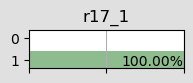
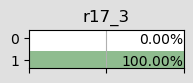
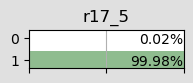
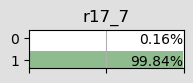

In [40]:
gnb.flow.clear()
for i in [1,3,5,7]:
    gnb.flow.add_html(gnb.getPosterior(ftts_dbn, target = "r17_{}".format(i), evs={'r52_0':0, 'r52_1':0, 'r52_2':0, 'r52_3':0, 'r52_4':0, 'r52_5':0, 'r52_6':0, 'r52_7':0}), "$P(a{})$".format(i))
gnb.flow.display()

In [ ]:
ftts_dbn_rooms =[e.split('_')[0]+('_') for e in ftts_dbn_nodes]

In [ ]:
#plt.rcParams['figure.figsize'] = (10, 2)
#gdyn.plotFollowUnrolled(ftts_dbn_rooms,ftts_dbn,T=8,evs={'r52_0':0, 'r52_1':0, 'r52_2':0, 'r52_3':0, 'r52_4':0, 'r52_5':0, 'r52_6':0, 'r52_7':0 })

In [ ]:
ftts_dbn.cpt('r29_0')

for node in dBN_nodes:
    dag_dBN.cpt(node)
    print(dag_dBN.cpt(node))

dag_dBN.cpt("r1_0").fillWith([0.74, 0.26, 0, 1])


dag_dBN.cpt("r53_0").names # 부모노드를 출력한다. 조건부확률의 조건


dag_dBN.cpt("r38_0").names


gnb.flow.clear()
for i in range(T):
    gnb.flow.add_html(gnb.getPosterior(unroll_dBN, target = "r1_{}".format(i), evs={}), "$P(a{})$".format(i))
gnb.flow.display()

sorted(ftts_dbn.names())